In [40]:
import numpy as np
from matplotlib import pyplot as plt
import os
import xml.etree.ElementTree as ET
import json
import matplotlib.patches as patches
import matplotlib.path as mpath
import matplotlib.patches as mpatches
import pandas as pd
import cv2
%matplotlib notebook

#defined a function to calculate the haversine distance between a set of coordinates
import numba
from numba import njit,prange
from math import radians, cos, sin, asin, sqrt
@njit()
def haversine(lon1, lat1, lon2, lat2):
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 =  lon1*np.pi/180, lat1*np.pi/180, lon2*np.pi/180, lat2*np.pi/180
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    r = 1737.4 # Radius of moon in kilometers.
    return c * r


## Ohrc preprocessing

In [ ]:
#extract data from xml and save to json
#convert img binary files to compressed numpy arrays with npz format
# the file structure should be like --> ohrc\ch2_ohr_ncp_20190906T1246532096_d_img_d18\data\calibrated\20190906\..img,...xml
path = 'ohrc/'
files = os.listdir(path)
for name in files:
    #filename
    folder = path+name+'/'+'data/calibrated/'
    filename = folder+ os.listdir(folder)[0]+'/'+name
    
    #this returns a dictionary with all the coordinates, offset and the pixel resolution from the xml
    tree = ET.parse(filename+'.xml')
    root = tree.getroot()
    dic = {}
    coords = {}
    for i in root[1][5][1][1]:
        coords[i.tag[40:]] = float(i.text)
    offset = float(root[2][1][0].text)
    shape = (int(root[2][1][4][1].text),int(root[2][1][5][1].text))
    pix_res = float(root[1][5][0][13].text)
    dic['coords'] = coords
    dic['offset'] = offset
    dic['shape'] = shape
    dic['pix_res'] = pix_res
    with open(filename+".json", "w") as outfile:
        json.dump(dic, outfile)
    
    #read the data from the binary .img file and save it as a compressed npz array
    dtype = np.dtype('>u1') # big-endian unsigned integer (1byte)
    fid = open(filename+'.img', 'rb')
    data = np.fromfile(fid, dtype)
    image = data.reshape(shape)
    np.savez_compressed(filename,image)

In [14]:
#delete the img files to release space
for name in files:
    folder = path+name+'/'+'data/calibrated/'
    filename = folder+ os.listdir(folder)[0]+'/'+name
    try:
        os.remove(filename+'.img')
    except:
        pass

In [63]:
#make a dataset with coordinates, offset,shape and pixres from the jsons
import pandas as pd
col_names = ['name']+list(coords.keys())+['offset','shape_x','shape_y','pix_res']
path = 'ohrc/'
files = os.listdir(path)
new_arr = []
for name in files:
    #filename
    folder = path+name+'/'+'data/calibrated/'
    filename = folder+ os.listdir(folder)[0]+'/'+name
    
    with open(filename+'.json') as json_file:
        dic = json.load(json_file)
    coords = dic['coords']
    offset = dic['offset']
    shape_x,shape_y = dic['shape'] 
    pix_res = dic['pix_res']
    arr = [name]
    for i in coords.values():
        arr.append(i)
    arr+=[offset,shape_x,shape_y,pix_res]
    new_arr.append(arr)
    
dataset = pd.DataFrame(new_arr,columns = col_names)
dataset.to_csv('coordinates_ohrc.csv',index = False)

In [80]:
#test
image = np.load(filename+'.npz')["arr_0"]
image

array([[41, 42, 43, ...,  0,  0,  0],
       [38, 44, 47, ...,  0,  0,  0],
       [41, 45, 48, ...,  3,  3,  2],
       ...,
       [32, 27, 23, ..., 31, 24, 23],
       [34, 29, 23, ..., 30, 23, 23],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint8)

<IPython.core.display.Javascript object>


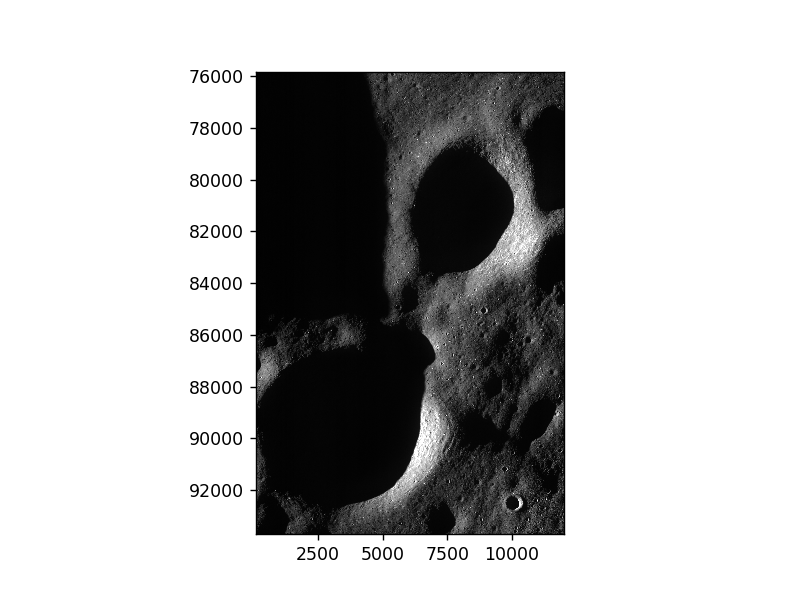

In [81]:
# Display
%matplotlib notebook
plt.imshow(image, cmap = "gray")
plt.show()

In [220]:
dataset_ohrc = pd.read_csv('coordinates_ohrc.csv')
dataset_ohrc

,name,upper_left_latitude,upper_left_longitude,upper_right_latitude,upper_right_longitude,lower_left_latitude,lower_left_longitude,lower_right_latitude,lower_right_longitude,offset,shape_x,shape_y,pix_res
0,ch2_ohr_ncp_20190906T1246532096_d_img_d18,-14.323756,71.334305,-16.729850,69.174869,-14.735024,71.445725,-17.156290,69.299801,0.0,63230,12000,0.270000
1,ch2_ohr_ncp_20200229T0739312111_d_img_d18,-74.366050,43.709461,-74.357976,43.359488,-73.524540,43.957706,-73.516771,43.625522,0.0,93693,12000,0.229770
2,ch2_ohr_ncp_20200229T0938004033_d_img_d32,-73.920405,42.799376,-73.912522,42.457137,-73.078883,43.031644,-73.071384,42.706306,0.0,93693,12000,0.230223
3,ch2_ohr_ncp_20200824T0806596861_d_img_d18,-61.610358,56.580435,-61.604458,56.804725,-62.441705,56.641651,-62.435771,56.871902,0.0,90148,12000,0.258557
4,ch2_ohr_ncp_20200824T1003365280_d_img_d18,-61.660467,56.577047,-61.657424,56.807375,-62.490045,56.666465,-62.486906,56.902936,0.0,93692,12000,0.258099
5,ch2_ohr_ncp_20200825T1127278043_d_img_d18,-68.362610,41.141334,-68.359820,41.420493,-69.197495,41.192520,-69.194672,41.482045,0.0,93693,12000,0.249503
6,ch2_ohr_ncp_20200825T1322594314_d_img_d18,-63.322785,39.459103,-63.322421,39.705735,-64.156508,39.482354,-64.156265,39.736163,0.0,90148,12000,0.251410
7,ch2_ohr_ncp_20200825T1521048453_d_img_d18,-68.334774,41.076553,-68.334153,41.367581,-69.165951,41.203266,-69.165367,41.505086,0.0,93692,12000,0.250834
8,ch2_ohr_ncp_20200825T1716291272_d_img_d18,-63.339232,39.451651,-63.338565,39.696512,-64.170288,39.532475,-64.169890,39.784420,0.0,93693,12000,0.252511
9,ch2_ohr_ncp_20200826T0459464752_d_img_d18,-65.800042,31.694944,-65.792962,31.958737,-66.631675,31.738132,-66.624930,32.010558,0.0,93693,12000,0.250982


In [297]:
links = [['ch2_tmc_ncn_20220112T1458093645_d_img_d32.zip',
  'https://pradan.issdc.gov.in/ch2/protected/downloadData/POST_OD/isda_archive/ch2_bundle/cho_bundle/nop/tmc_collection/data/calibrated/20220112/ch2_tmc_ncn_20220112T1458093645_d_img_d32.zip?tmc2'],
 ['ch2_tmc_ncn_20220112T1458093645_d_img_d32.zip',
  'https://pradan.issdc.gov.in/ch2/protected/downloadData/POST_OD/isda_archive/ch2_bundle/cho_bundle/nop/tmc_collection/data/calibrated/20220112/ch2_tmc_ncn_20220112T1458093645_d_img_d32.zip?tmc2'],
 ['ch2_tmc_ncn_20220127T2215296303_d_img_d18.zip',
  'https://pradan.issdc.gov.in/ch2/protected/downloadData/POST_OD/isda_archive/ch2_bundle/cho_bundle/nop/tmc_collection/data/calibrated/20220127/ch2_tmc_ncn_20220127T2215296303_d_img_d18.zip?tmc2'],
 ['ch2_tmc_ncn_20220112T1102281958_d_img_d32.zip',
  'https://pradan.issdc.gov.in/ch2/protected/downloadData/POST_OD/isda_archive/ch2_bundle/cho_bundle/nop/tmc_collection/data/calibrated/20220112/ch2_tmc_ncn_20220112T1102281958_d_img_d32.zip?tmc2'],
 ['ch2_tmc_ncn_20220112T1102281958_d_img_d32.zip',
  'https://pradan.issdc.gov.in/ch2/protected/downloadData/POST_OD/isda_archive/ch2_bundle/cho_bundle/nop/tmc_collection/data/calibrated/20220112/ch2_tmc_ncn_20220112T1102281958_d_img_d32.zip?tmc2'],
 ['ch2_tmc_ncn_20220722T0106188066_d_img_d32.zip',
  'https://pradan.issdc.gov.in/ch2/protected/downloadData/POST_OD/isda_archive/ch2_bundle/cho_bundle/nop/tmc_collection/data/calibrated/20220722/ch2_tmc_ncn_20220722T0106188066_d_img_d32.zip?tmc2'],
 ['ch2_tmc_ncn_20220722T0106188066_d_img_d32.zip',
  'https://pradan.issdc.gov.in/ch2/protected/downloadData/POST_OD/isda_archive/ch2_bundle/cho_bundle/nop/tmc_collection/data/calibrated/20220722/ch2_tmc_ncn_20220722T0106188066_d_img_d32.zip?tmc2'],
 ['ch2_tmc_ncn_20220722T0106188066_d_img_d32.zip',
  'https://pradan.issdc.gov.in/ch2/protected/downloadData/POST_OD/isda_archive/ch2_bundle/cho_bundle/nop/tmc_collection/data/calibrated/20220722/ch2_tmc_ncn_20220722T0106188066_d_img_d32.zip?tmc2'],
 ['ch2_tmc_ncn_20220722T0106188066_d_img_d32.zip',
  'https://pradan.issdc.gov.in/ch2/protected/downloadData/POST_OD/isda_archive/ch2_bundle/cho_bundle/nop/tmc_collection/data/calibrated/20220722/ch2_tmc_ncn_20220722T0106188066_d_img_d32.zip?tmc2'],
 ['ch2_tmc_ncn_20220722T0106188066_d_img_d32.zip',
  'https://pradan.issdc.gov.in/ch2/protected/downloadData/POST_OD/isda_archive/ch2_bundle/cho_bundle/nop/tmc_collection/data/calibrated/20220722/ch2_tmc_ncn_20220722T0106188066_d_img_d32.zip?tmc2'],
 ['ch2_tmc_ncn_20220722T0106188066_d_img_d32.zip',
  'https://pradan.issdc.gov.in/ch2/protected/downloadData/POST_OD/isda_archive/ch2_bundle/cho_bundle/nop/tmc_collection/data/calibrated/20220722/ch2_tmc_ncn_20220722T0106188066_d_img_d32.zip?tmc2'],
 ['ch2_tmc_ncn_20220722T0106188066_d_img_d32.zip',
  'https://pradan.issdc.gov.in/ch2/protected/downloadData/POST_OD/isda_archive/ch2_bundle/cho_bundle/nop/tmc_collection/data/calibrated/20220722/ch2_tmc_ncn_20220722T0106188066_d_img_d32.zip?tmc2'],
 ['ch2_tmc_ncn_20220722T0106188066_d_img_d32.zip',
  'https://pradan.issdc.gov.in/ch2/protected/downloadData/POST_OD/isda_archive/ch2_bundle/cho_bundle/nop/tmc_collection/data/calibrated/20220722/ch2_tmc_ncn_20220722T0106188066_d_img_d32.zip?tmc2'],
 ['ch2_tmc_ncn_20220129T0541079533_d_img_d18.zip',
  'https://pradan.issdc.gov.in/ch2/protected/downloadData/POST_OD/isda_archive/ch2_bundle/cho_bundle/nop/tmc_collection/data/calibrated/20220129/ch2_tmc_ncn_20220129T0541079533_d_img_d18.zip?tmc2'],
 ['ch2_tmc_ncn_20191125T0749024692_d_img_d18.zip',
  'https://pradan.issdc.gov.in/ch2/protected/downloadData/POST_OD/isda_archive/ch2_bundle/cho_bundle/nop/tmc_collection/data/calibrated/20191125/ch2_tmc_ncn_20191125T0749024692_d_img_d18.zip?tmc2'],
 ['ch2_tmc_ncn_20191125T0749024692_d_img_d18.zip',
  'https://pradan.issdc.gov.in/ch2/protected/downloadData/POST_OD/isda_archive/ch2_bundle/cho_bundle/nop/tmc_collection/data/calibrated/20191125/ch2_tmc_ncn_20191125T0749024692_d_img_d18.zip?tmc2']]

In [355]:
#all the needed tmc files 
set(arr1)

{'20191125T0749024692_d_img_d18.zip',
 '20220112T1102281958_d_img_d32.zip',
 '20220112T1458093645_d_img_d32.zip',
 '20220127T2215296303_d_img_d18.zip',
 '20220129T0541079533_d_img_d18.zip',
 '20220722T0106188066_d_img_d32.zip'}

## tmc2 preprocessing

In [11]:
coords

{'upper_left_latitude': -0.362162,
 'upper_left_longitude': 234.123049,
 'upper_right_latitude': -0.368352,
 'upper_right_longitude': 234.61436,
 'lower_left_latitude': 29.020398,
 'lower_left_longitude': 234.476619,
 'lower_right_latitude': 29.012939,
 'lower_right_longitude': 235.051837}

In [380]:
#tmc preprocessing
#extract data from xml and save to json
#convert img binary files to compressed numpy arrays with npz format
#directory structure --> tmc2\ch2_tmc_ncn_20191125T0749024692_d_img_d18\data\calibrated\20191125\..img,...xml

path = 'tmc2/'
files = os.listdir(path)
for name in files:
    #filename
    folder = path+name+'/'+'data/calibrated/'
    filename = folder+ os.listdir(folder)[0]+'/'+name
    
    print(name)
    #extract the coordinates,shape,offset and pixel resolution from the xml
    tree = ET.parse(filename+'.xml')
    root = tree.getroot()
    dic = {}
    coords = {}
    for i in root[1][5][1][1]:
        coords[i.tag[40:]] = float(i.text)
    offset = float(root[2][1][0].text)
    shape = (int(root[2][1][4][1].text),int(root[2][1][5][1].text))
    pix_res = float(root[1][5][0][13].text)
    dic['coords'] = coords
    dic['offset'] = offset
    dic['shape'] = shape
    dic['pix_res'] = pix_res
    with open(filename+".json", "w") as outfile:
        json.dump(dic, outfile)
        
    #convert the binary .img file to compressed npz array 
    dtype = np.dtype('<u2') # less-endian unsigned integer (1byte)
    fid = open(filename+'.img', 'rb')
    data = np.fromfile(fid, dtype)
    image = data.reshape(shape)
    np.savez_compressed(filename,image)
 

ch2_tmc_ncn_20191125T0749024692_d_img_d18
ch2_tmc_ncn_20220112T1102281958_d_img_d32
ch2_tmc_ncn_20220112T1458093645_d_img_d32
ch2_tmc_ncn_20220127T2215296303_d_img_d18
ch2_tmc_ncn_20220129T0541079533_d_img_d18
ch2_tmc_ncn_20220722T0106188066_d_img_d32


In [378]:
image

array([[321, 346, 345, ..., 415, 419, 424],
       [343, 356, 345, ..., 410, 414, 417],
       [335, 362, 358, ..., 409, 412, 421],
       ...,
       [251, 246, 245, ..., 265, 272, 277],
       [252, 248, 249, ..., 269, 273, 279],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint16)

<IPython.core.display.Javascript object>


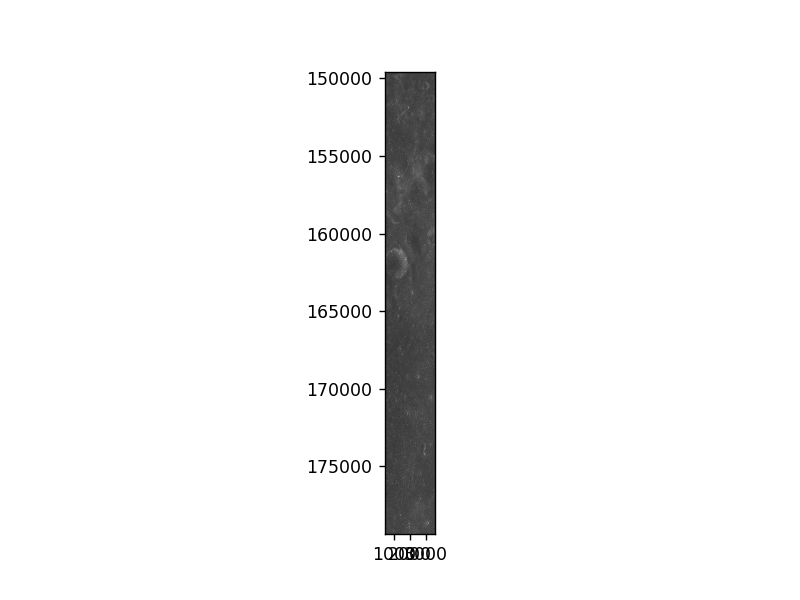

In [7]:
#test
%matplotlib inline
path = 'tmc2/'
name = files[5]
folder = path+name+'/'+'data/calibrated/'
filename = folder+ os.listdir(folder)[0]+'/'+name
image = np.load(filename+'.npz')["arr_0"]
plt.imshow(image, cmap = "gray")
plt.show()


In [ ]:
#delete the img files to release space
for name in files:
    folder = path+name+'/'+'data/calibrated/'
    filename = folder+ os.listdir(folder)[0]+'/'+name
    try:
        os.remove(filename+'.img')
    except:
        pass

In [12]:
#make a dataset with coordinates, offset,shape and pixres from the jsons
import pandas as pd
col_names = ['name']+list(coords.keys())+['offset','shape_x','shape_y','pix_res']
path = 'tmc2/'
files = os.listdir(path)
new_arr = []
for name in files:
    #filename
    folder = path+name+'/'+'data/calibrated/'
    filename = folder+ os.listdir(folder)[0]+'/'+name
    
    with open(filename+'.json') as json_file:
        dic = json.load(json_file)
    coords = dic['coords']
    offset = dic['offset']
    shape_x,shape_y = dic['shape'] 
    pix_res = dic['pix_res']
    arr = [name]
    for i in coords.values():
        arr.append(i)
    arr+=[offset,shape_x,shape_y,pix_res]
    new_arr.append(arr)
    
dataset = pd.DataFrame(new_arr,columns = col_names)
dataset.to_csv('matched_coordinates_tmc2.csv',index = False)

In [13]:
dataset

,name,upper_left_latitude,upper_left_longitude,upper_right_latitude,upper_right_longitude,lower_left_latitude,lower_left_longitude,lower_right_latitude,lower_right_longitude,offset,shape_x,shape_y,pix_res
0,ch2_tmc_ncn_20191125T0749024692_d_img_d18,-0.362162,234.123049,-0.368352,234.614360,29.020398,234.476619,29.012939,235.051837,0.0,174040,4000,3.96
1,ch2_tmc_ncn_20220112T1102281958_d_img_d32,-74.551355,222.222026,-74.536058,224.672578,-59.504158,42.073770,-59.497987,40.908976,0.0,276917,4000,4.48
2,ch2_tmc_ncn_20220112T1458093645_d_img_d32,-74.548860,219.807416,-74.536386,222.244304,-59.481443,39.992079,-59.476597,38.833240,0.0,276918,4000,4.46
3,ch2_tmc_ncn_20220127T2215296303_d_img_d18,-74.355094,16.797098,-74.364355,19.412865,-59.814266,199.751430,-59.820007,198.515699,0.0,278168,4000,4.71
4,ch2_tmc_ncn_20220129T0541079533_d_img_d18,-74.790458,359.676149,-74.796572,2.282354,-59.330124,182.268665,-59.333684,181.079720,0.0,277555,4000,4.60
5,ch2_tmc_ncn_20220722T0106188066_d_img_d32,31.278721,231.754047,31.282044,230.696030,1.392010,231.611033,1.389625,230.725154,0.0,188318,4000,6.70


## crop

In [42]:
#pairs of files which overlap based on the given coordinates

pairs = [['ch2_ohr_ncp_20200825T1127278043_d_img_d18','ch2_tmc_ncn_20220112T1102281958_d_img_d32'],
 ['ch2_ohr_ncp_20200825T1322594314_d_img_d18','ch2_tmc_ncn_20220112T1458093645_d_img_d32'],
 ['ch2_ohr_ncp_20200825T1521048453_d_img_d18','ch2_tmc_ncn_20220112T1102281958_d_img_d32'],
 ['ch2_ohr_ncp_20200825T1716291272_d_img_d18','ch2_tmc_ncn_20220112T1458093645_d_img_d32'],
 ['ch2_ohr_ncp_20220128T0018149733_d_img_d18','ch2_tmc_ncn_20220127T2215296303_d_img_d18'],
 ['ch2_ohr_ncp_20220129T0150171705_d_img_d18','ch2_tmc_ncn_20220129T0541079533_d_img_d18'],
 ['ch2_ohr_ncp_20220321T0326368312_d_img_hw1','ch2_tmc_ncn_20220722T0106188066_d_img_d32'],
 ['ch2_ohr_ncp_20220321T0326369085_d_img_d18','ch2_tmc_ncn_20220722T0106188066_d_img_d32'],
 ['ch2_ohr_ncp_20220321T0326369860_d_img_d18','ch2_tmc_ncn_20220722T0106188066_d_img_d32'],
 ['ch2_ohr_ncp_20220321T0525225877_d_img_hw1','ch2_tmc_ncn_20220722T0106188066_d_img_d32'],
 ['ch2_ohr_ncp_20220321T0525226030_d_img_d18','ch2_tmc_ncn_20220722T0106188066_d_img_d32'],
 ['ch2_ohr_ncp_20220321T0525226107_d_img_d18','ch2_tmc_ncn_20220722T0106188066_d_img_d32'],
 ['ch2_ohr_ncp_20220321T0525376958_d_img_hw1','ch2_tmc_ncn_20220722T0106188066_d_img_d32'],
 ['ch2_ohr_ncp_20220321T0525382085_d_img_hw1','ch2_tmc_ncn_20220722T0106188066_d_img_d32'],
 ['ch2_ohr_ncp_20220914T0835371412_d_img_d32','ch2_tmc_ncn_20191125T0749024692_d_img_d18'],
 ['ch2_ohr_ncp_20220914T1033119094_d_img_d32','ch2_tmc_ncn_20191125T0749024692_d_img_d18']]

#load the coordinates of the ohrc files so that we may extract the corners of the images
coords_ohrc = pd.read_csv('coordinates_ohrc.csv')

In [43]:
#load the tmc image from a pair from the list 
[ohr,tmc] = pairs[0]
folder_tmc2 = 'tmc2/'+tmc+'/'+'data/calibrated/'
filename_tmc2 = folder_tmc2+ os.listdir(folder_tmc2)[0]+'/'+tmc
im_tmc = np.load(filename_tmc2+'.npz')['arr_0']

#extract the corner coordinates of the paired ohrc file in the given format
#corners = [[lat, long],[...],...]
arr1 = np.array(coords_ohrc[coords_ohrc['name'] == ohr])[0][1:]
ul = [arr1[0],arr1[1]]
ur = [arr1[2],arr1[3]]
ll = [arr1[4],arr1[5]]
lr = [arr1[6],arr1[7]]
corners = np.array([ul,ur,lr,ll])

#load the geometry information of the paired tmc so that we can search the corner coordinates of the ohrc in the tmc
folder_geo_tmc2 = 'tmc2/'+tmc+'/'+'geometry/calibrated/'
filename_geo_tmc2 = folder_geo_tmc2+ os.listdir(folder_geo_tmc2)[0]+'/'
filename_geo_tmc2 += os.listdir(filename_geo_tmc2)[0]
detailed_coords = pd.read_csv(filename_geo_tmc2)
# detailed_coords = pd.read_csv('ohr8043.csv')

#load geometric information of the ohrc
folder_geo_ohr = 'ohrc/'+ohr+'/'+'geometry/calibrated/'
filename_geo_ohr = folder_geo_ohr+ os.listdir(folder_geo_ohr)[0]+'/'
filename_geo_ohr += os.listdir(filename_geo_ohr)[0]
detailed_coords_ohr = pd.read_csv(filename_geo_ohr)

#load the ohrc array
%matplotlib notebook
path = 'ohrc/'
name = ohr
folder = path+name+'/'+'data/calibrated/'
filename = folder+ os.listdir(folder)[0]+'/'+name
image = np.load(filename+'.npz')["arr_0"]

In [44]:
detailed_coords_ohr

,Longitude,Latitude,Pixel,Scan
0,41.141334,-68.362610,0,0
1,41.143660,-68.362589,100,0
2,41.145986,-68.362567,200,0
3,41.148311,-68.362546,300,0
4,41.150637,-68.362525,400,0
...,...,...,...,...
113493,41.472414,-69.194774,11600,93692
113494,41.474828,-69.194749,11700,93692
113495,41.477241,-69.194723,11800,93692
113496,41.479655,-69.194697,11900,93692


In [76]:
# 2000 patches and their corners

# det_ohr_arr = np.array(detailed_coords_ohr)
# #scan, pixel
# ixs = [0,0]
# dim = 2000
# #ul ur lr ll
# pix_c = np.array([ixs,[ixs[1],ixs[0]+dim],[ixs[1]+dim,ixs[0]+dim],[ixs[1]+dim,ixs[0]]])
# corners = []
# for i in range(4):
#     [scan,pix] = pix_c[i]
#     ar = det_ohr_arr[det_ohr_arr[:,3] == scan]
#     corners.append([ar[ar[:,2] == pix][:,:2][0][1],ar[ar[:,2] == pix][:,:2][0][0]])
# corners = np.array(corners)
# detailed_coords = pd.read_csv('interpolatedch2_ohr_ncp_20200825T1127278043_d_img_d18.csv')

In [60]:
print('ul ur lr ll')
corners

ul ur lr ll


array([[-68.36261 ,  41.141334],
       [-68.35982 ,  41.420493],
       [-69.194672,  41.482045],
       [-69.197495,  41.19252 ]])

In [53]:
#corners = [[lat, long],[...],...]
# corners = [ul,ur,lr,ll]
#find the pixel coordinates of the corners of ohrc within tmc
have_dist = np.zeros((len(detailed_coords),4))
lonlat = np.array(detailed_coords)[:,:2]
for i in prange(len(have_dist)):
    have_dist[i] = haversine(corners[:,1],corners[:,0],lonlat[i][0],lonlat[i][1])
#ul,ur,lr,ll
ixs = np.argmin(have_dist,axis = 0)
#pixel and scan = (scan,pixel)
pixel_coords = np.zeros((4,2),dtype = np.int32)
for i in range(4):
    pixel_coords[i] = np.array(detailed_coords)[ixs[i],2:4]

pixel_coords

array([[  2200, 223700],
       [  1600, 223700],
       [  1300, 218700],
       [  2000, 218700]])

In [54]:
corners

array([[-68.36261 ,  41.141334],
       [-68.35982 ,  41.420493],
       [-69.194672,  41.482045],
       [-69.197495,  41.19252 ]])

In [49]:
# more precise coordinates interpolated using pygeodesy
# pixel_coords = np.array([[  2237,223722],
#           [  1552,223748],
#           [  1340,218732],
#           [  2023,218707]])

# pixel_coords[0][0] = min(pixel_coords[0][0]+100,im_tmc.shape[1])
# pixel_coords[3][0] = min(pixel_coords[3][0]+100,im_tmc.shape[1])
# pixel_coords[1][0] = max(pixel_coords[1][0]-100,0)
# pixel_coords[2][0] = max(pixel_coords[2][0]-100,0)
# pixel_coords[0][1] = min(pixel_coords[0][1]+100,im_tmc.shape[0])
# pixel_coords[1][1] = min(pixel_coords[1][1]+100,im_tmc.shape[0])
# pixel_coords[2][1] = max(pixel_coords[2][1]-100,0)
# pixel_coords[3][1] = max(pixel_coords[3][1]-100,0)
# pixel_coords
pixel_coords

array([[  2237, 223722],
       [  1552, 223748],
       [  1340, 218732],
       [  2023, 218707]])

In [55]:
#manual correction
pixel_coords[1][0] = 1500
pixel_coords[:,0]+=153+104
pixel_coords[:,1]+=680
#define a bounding box for the ohrc within tmc to reduce the search space
maxs,mins = pixel_coords.max(axis = 0),pixel_coords.min(axis = 0)
bounding_box = im_tmc[int(mins[1]):int(maxs[1]),int(mins[0]):int(maxs[0])]
box_pix_coords = pixel_coords.copy()
box_pix_coords[:,0] -= mins[0]
box_pix_coords[:,1] -= mins[1]
box_pix_coords

array([[ 900, 5000],
       [ 200, 5000],
       [   0,    0],
       [ 700,    0]])

In [56]:
# mask the area in the bounding box which is not in ohrc image 
# rotates/skews/flips the image accordingly
bb = bounding_box
bb_maxs = box_pix_coords.max(axis = 0)
bb_mins = box_pix_coords.min(axis = 0)
mask = np.zeros((bb.shape[0], bb.shape[1]))
cv2.fillConvexPoly(mask, box_pix_coords, 1)
mask = mask.astype(bool)
out = np.zeros_like(bb)
out[mask] = bb[mask]
patch = bb[mask]
# create a subimage with the outer limits of the points
subimg = out[bb_mins[1]:bb_maxs[1],bb_mins[0]:bb_maxs[0]]
a = max(abs(box_pix_coords[3][0]-box_pix_coords[2][0]),abs(box_pix_coords[1][0]-box_pix_coords[0][0]))
subimg__ = np.zeros((subimg.shape[0],a))
for i in range(len(subimg)):
    row = subimg[i]
    for j in range(len(subimg[0])):
        if row[j] != 0 :
            if len(row[j:])>a:
                subimg__[i] = row[j:j+a]
            else:
                subimg__[i][:len(row[j:])] = row[j:]
            break
            
subimg__ = np.rot90(subimg__,k = 2)

<IPython.core.display.Javascript object>


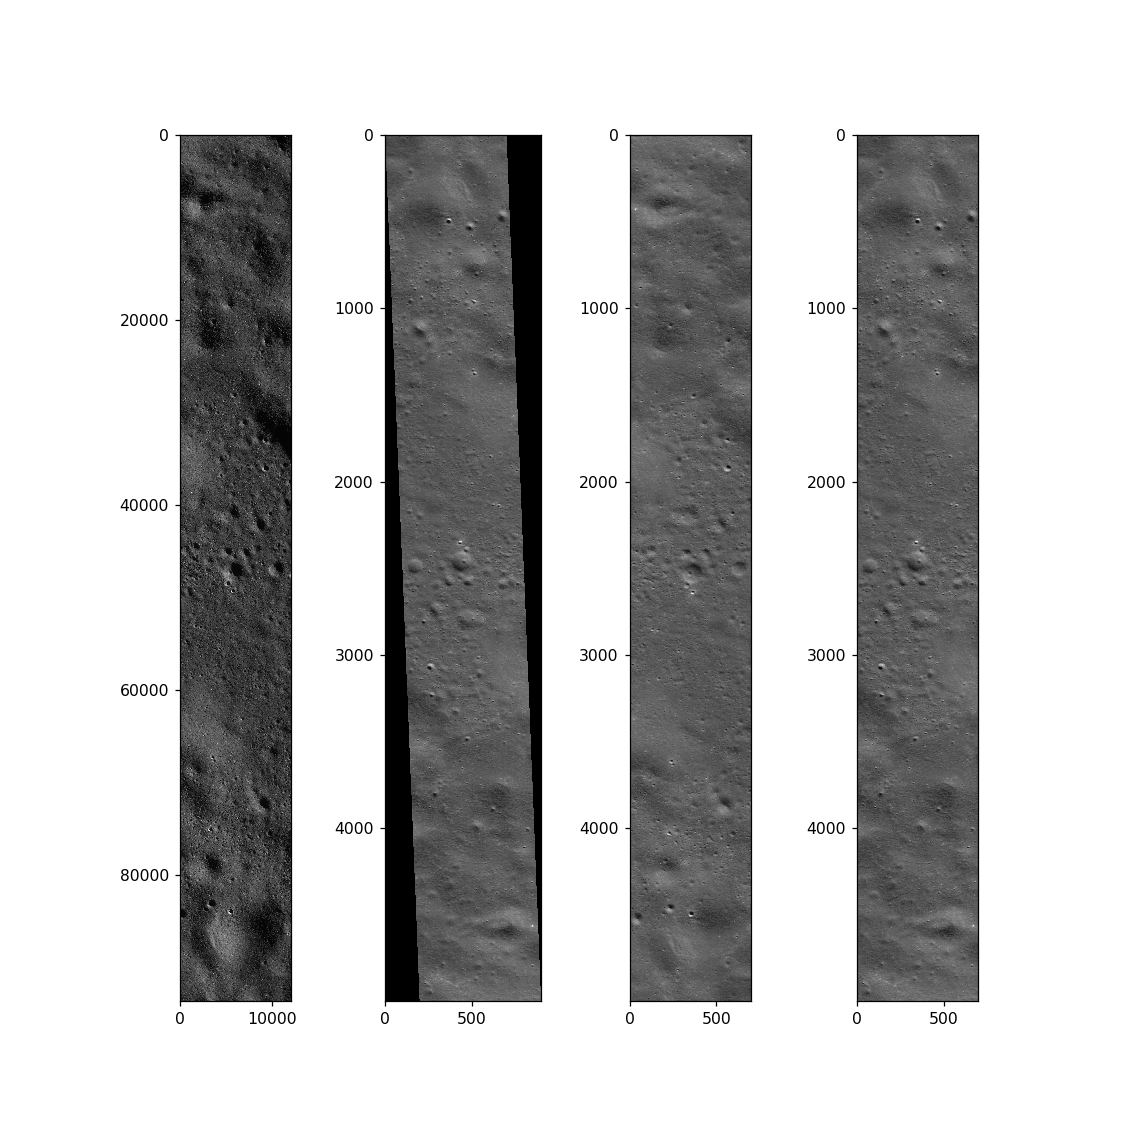

In [57]:
fig,ax = plt.subplots(1,4,figsize = (10,10))
ax[0].imshow(image,cmap = 'gray',label = 'ohrc')
ax[1].imshow(subimg, cmap = "gray",label='tmc')
ax[2].imshow(subimg__, cmap = "gray",label='rotated_tmc')
ax[3].imshow(np.rot90(subimg__,k = 2),cmap ='gray',label = 'tmc')

<IPython.core.display.Javascript object>


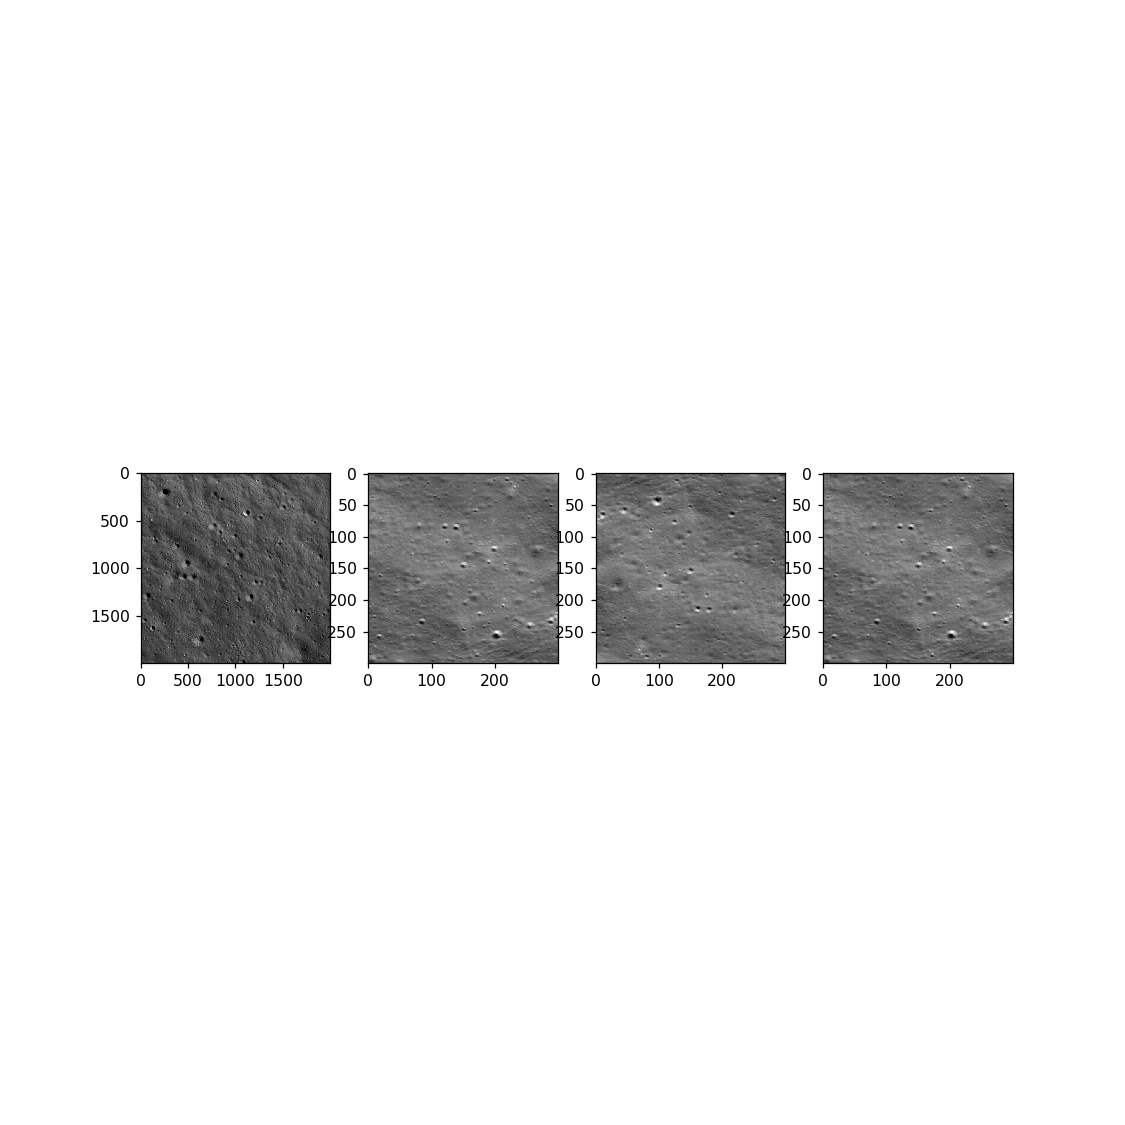

In [85]:
# fig,ax = plt.subplots(1,4,figsize = (10,10))
# ax[0].imshow(image[:2000,:2000],cmap = 'gray',label = 'ohrc')
# ax[1].imshow(subimg, cmap = "gray",label='tmc')
# ax[2].imshow(subimg__, cmap = "gray",label='rotated_tmc')
# ax[3].imshow(np.rot90(subimg__,k = 2),cmap ='gray',label = 'tmc')


In [60]:
#some calculations for coordinate corrections
5400/12000,47200/93693
162/,1838
214/700
center = [int(subimg__.shape[0]*0.50377),int(subimg__.shape[1]*0.45)]
center[0]-1838,center[1]-214

(0.45, 0.5037729606267277)

In [80]:
#this part is used to rotate the image if necessary according to the angle formed by the image with the horizontal
import math
# calculate the angle between the 2 'lowest' points, the 'bottom' line
myradians = math.atan2(box_pix_coords[2][0]-box_pix_coords[3][0], box_pix_coords[2][1]-box_pix_coords[3][1])
# convert to degrees 
mydegrees = 90-math.degrees(myradians)
# create rotationmatrix
h,w = subimg.shape[:2]
center = (h/2,w/2)
M = cv2.getRotationMatrix2D(center, -2, 1)
# rotate subimage
rotatedImg = cv2.warpAffine(subimg, M, (w, h))

<IPython.core.display.Javascript object>


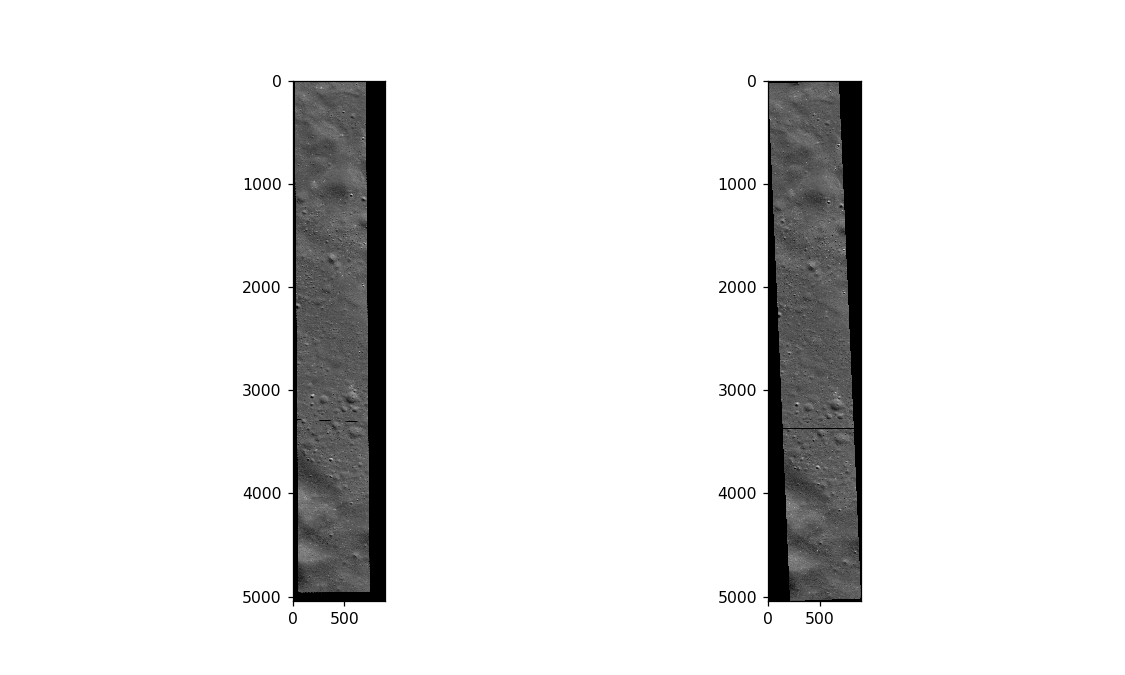

In [82]:
fig,ax = plt.subplots(1,2,figsize = (10,6))
ax[0].imshow(rotatedImg,cmap = 'gray')
ax[1].imshow(subimg,cmap = 'gray')

In [51]:
# strip the image from the matrix not including the black portions
arrr = rotatedImg
subimg__ = np.zeros((arrr.shape[0],max(abs(box_pix_coords[0][0]-box_pix_coords[1][0]),abs(box_pix_coords[2][0]-box_pix_coords[3][0]))))
for i in range(len(arrr)):
    row = subimg[i]
    for j in range(len(arrr[0])):
        if row[j] != 0 :
            if len(row[j:])>685:
                subimg__[i] = row[j:j+685]
            else:
                subimg__[i][:len(row[j:])] = row[j:]
            break
            

#save the cropped tmc image to an array
np.savez_compressed('better_cropped_tmc',np.rot90(subimg__,k = 2))


## Streamlined

In [3]:
#pairs of files which overlap based on the given coordinates

pairs = [['ch2_ohr_ncp_20200825T1127278043_d_img_d18','ch2_tmc_ncn_20220112T1102281958_d_img_d32'],
 ['ch2_ohr_ncp_20200825T1322594314_d_img_d18','ch2_tmc_ncn_20220112T1458093645_d_img_d32'],
 ['ch2_ohr_ncp_20200825T1521048453_d_img_d18','ch2_tmc_ncn_20220112T1102281958_d_img_d32'],
 ['ch2_ohr_ncp_20200825T1716291272_d_img_d18','ch2_tmc_ncn_20220112T1458093645_d_img_d32'],
 ['ch2_ohr_ncp_20220128T0018149733_d_img_d18','ch2_tmc_ncn_20220127T2215296303_d_img_d18'],
 ['ch2_ohr_ncp_20220129T0150171705_d_img_d18','ch2_tmc_ncn_20220129T0541079533_d_img_d18'],
 ['ch2_ohr_ncp_20220321T0326368312_d_img_hw1','ch2_tmc_ncn_20220722T0106188066_d_img_d32'],
 ['ch2_ohr_ncp_20220321T0326369085_d_img_d18','ch2_tmc_ncn_20220722T0106188066_d_img_d32'],
 ['ch2_ohr_ncp_20220321T0326369860_d_img_d18','ch2_tmc_ncn_20220722T0106188066_d_img_d32'],
 ['ch2_ohr_ncp_20220321T0525225877_d_img_hw1','ch2_tmc_ncn_20220722T0106188066_d_img_d32'],
 ['ch2_ohr_ncp_20220321T0525226030_d_img_d18','ch2_tmc_ncn_20220722T0106188066_d_img_d32'],
 ['ch2_ohr_ncp_20220321T0525226107_d_img_d18','ch2_tmc_ncn_20220722T0106188066_d_img_d32'],
 ['ch2_ohr_ncp_20220321T0525376958_d_img_hw1','ch2_tmc_ncn_20220722T0106188066_d_img_d32'],
 ['ch2_ohr_ncp_20220321T0525382085_d_img_hw1','ch2_tmc_ncn_20220722T0106188066_d_img_d32'],
 ['ch2_ohr_ncp_20220914T0835371412_d_img_d32','ch2_tmc_ncn_20191125T0749024692_d_img_d18'],
 ['ch2_ohr_ncp_20220914T1033119094_d_img_d32','ch2_tmc_ncn_20191125T0749024692_d_img_d18']]

#load the coordinates of the ohrc files so that we may extract the corners of the images
coords_ohrc = pd.read_csv('coordinates_ohrc.csv')

In [35]:
# load the pair of ohrc and tmc files
#only 0,14,15 usable
[ohr,tmc] = pairs[9]
folder_tmc2 = 'tmc2/'+tmc+'/'+'data/calibrated/'
filename_tmc2 = folder_tmc2+ os.listdir(folder_tmc2)[0]+'/'+tmc
im_tmc = np.load(filename_tmc2+'.npz')['arr_0']

#extract the corners of the ohrc patch
#corners = [[lat, long],[...],...] full image coordinates
arr1 = np.array(coords_ohrc[coords_ohrc['name'] == ohr])[0][1:]
ul = [arr1[0],arr1[1]]
ur = [arr1[2],arr1[3]]
ll = [arr1[4],arr1[5]]
lr = [arr1[6],arr1[7]]
corners = [ul,ur,lr,ll]

#load geometry of the tmc file
folder_geo_tmc2 = 'tmc2/'+tmc+'/'+'geometry/calibrated/'
filename_geo_tmc2 = folder_geo_tmc2+ os.listdir(folder_geo_tmc2)[0]+'/'
filename_geo_tmc2 += os.listdir(filename_geo_tmc2)[0]
detailed_coords = pd.read_csv(filename_geo_tmc2)
# detailed_coords = pd.read_csv('ohr8043.csv')

#load geometry of the ohrc file
folder_geo_ohr = 'ohrc/'+ohr+'/'+'geometry/calibrated/'
filename_geo_ohr = folder_geo_ohr+ os.listdir(folder_geo_ohr)[0]+'/'
filename_geo_ohr += os.listdir(filename_geo_ohr)[0]
detailed_coords_ohr = pd.read_csv(filename_geo_ohr)

#load ohrc
%matplotlib notebook
path = 'ohrc/'
name = ohr
folder = path+name+'/'+'data/calibrated/'
filename = folder+ os.listdir(folder)[0]+'/'+name
image = np.load(filename+'.npz')["arr_0"]



In [36]:
#find the pixel coordinates of the ohrc patch in the tmc image by matching coordinates using haversine distance
#corners = [[lat, long],[...],...]
# corners = [ul,ur,lr,ll]
corners = np.array(corners)
have_dist = np.zeros((len(detailed_coords),4))
lonlat = np.array(detailed_coords)[:,:2]
for i in prange(len(have_dist)):
    have_dist[i] = haversine(corners[:,1],corners[:,0],lonlat[i][0],lonlat[i][1])
#ul,ur,lr,ll
ixs = np.argmin(have_dist,axis = 0)

#pixel and scan = (scan,pixel)
pixel_coords = np.zeros((4,2),dtype = np.int32)
for i in range(4):
    pixel_coords[i] = np.array(detailed_coords)[ixs[i],2:4]

pixel_coords

array([[  2800, 169900],
       [  3300, 169800],
       [  3300, 164400],
       [  2700, 164500]])

In [32]:
# #manual correction in the pixel coordinates
pixel_coords[:,0]+=200
pixel_coords[:,1]-=625
pixel_coords

array([[ 1900, 35725],
       [ 2900, 35725],
       [ 3000, 30825],
       [ 2000, 30825]])

In [37]:
#define the bounding box for the patch of image
maxs,mins = pixel_coords.max(axis = 0),pixel_coords.min(axis = 0)
bounding_box = im_tmc[int(mins[1]):int(maxs[1]),int(mins[0]):int(maxs[0])]
box_pix_coords = pixel_coords.copy()
box_pix_coords[:,0] -= mins[0]
box_pix_coords[:,1] -= mins[1]
box_pix_coords

array([[ 100, 5500],
       [ 600, 5400],
       [ 600,    0],
       [   0,  100]])

In [69]:
# mask the area in the bounding box which is not in ohrc image 
# rotates/skews/flips the image accordingly
bb = bounding_box
bb_maxs = box_pix_coords.max(axis = 0)
bb_mins = box_pix_coords.min(axis = 0)
mask = np.zeros((bb.shape[0], bb.shape[1]))
cv2.fillConvexPoly(mask, box_pix_coords, 1)
mask = mask.astype(bool)
out = np.zeros_like(bb)
out[mask] = bb[mask]
patch = bb[mask]
# create a subimage with the outer limits of the points
subimg = out[bb_mins[1]:bb_maxs[1],bb_mins[0]:bb_maxs[0]]
a = max(abs(box_pix_coords[3][0]-box_pix_coords[2][0]),abs(box_pix_coords[1][0]-box_pix_coords[0][0]))
subimg__ = np.zeros((subimg.shape[0],a))
for i in range(len(subimg)):
    row = subimg[i]
    for j in range(len(subimg[0])):
        if row[j] != 0 :
            if len(row[j:])>a:
                subimg__[i] = row[j:j+a]
            else:
                subimg__[i][:len(row[j:])] = row[j:]
            break
            
subimg__ = np.rot90(subimg__,k = 2)

<IPython.core.display.Javascript object>


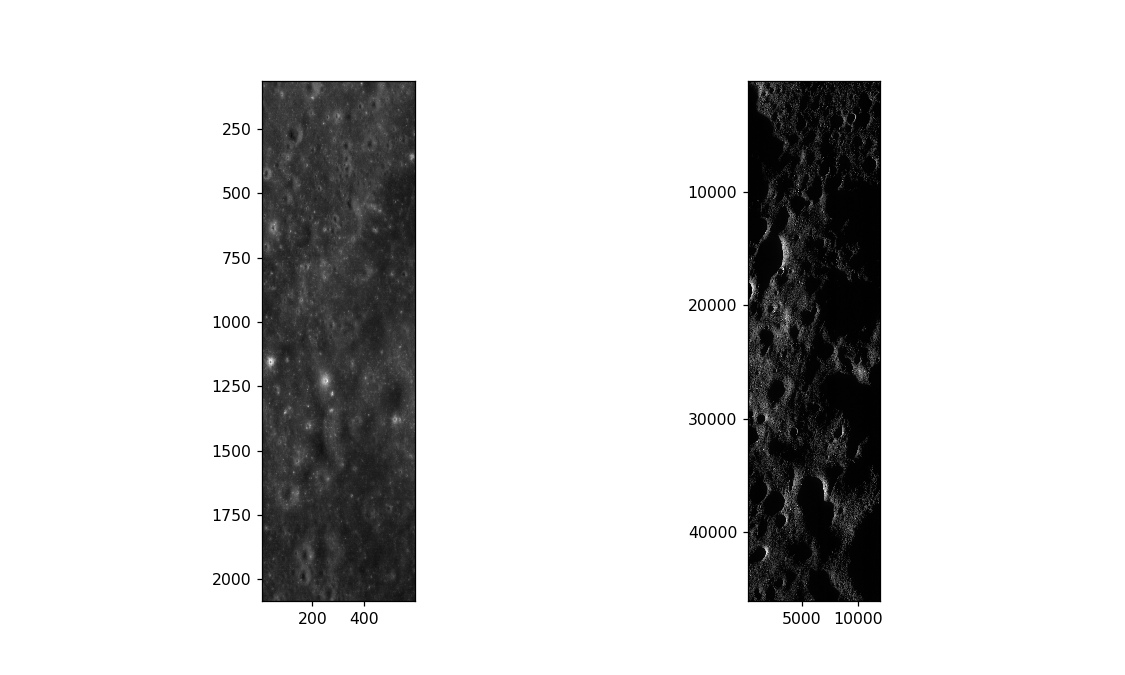

In [39]:
fig,ax = plt.subplots(1,2,figsize = (10,6))
ax[0].imshow(bounding_box, cmap = "gray")
ax[1].imshow(image,cmap ='gray')

<IPython.core.display.Javascript object>


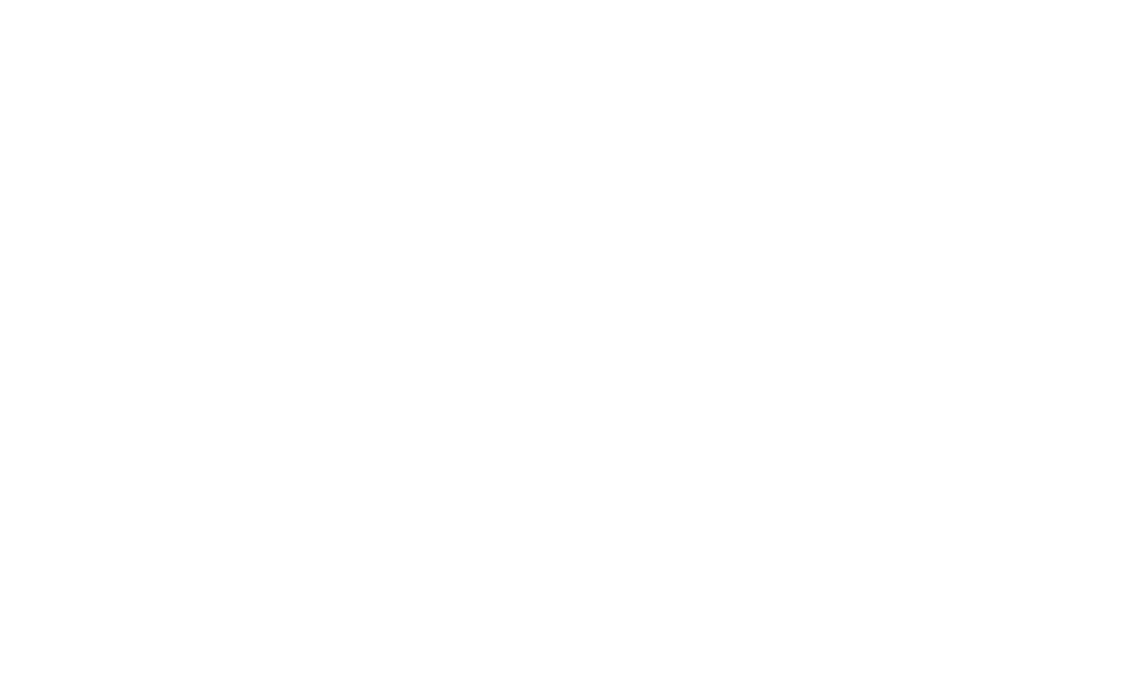

NameError: name 'subimg' is not defined

In [38]:
fig,ax = plt.subplots(1,4,figsize = (10,6))
ax[0].imshow(image,cmap = 'gray',label = 'ohrc')
ax[1].imshow(subimg, cmap = "gray",label='tmc')
ax[2].imshow(np.fliplr(subimg__), cmap = "gray",label='rotated_tmc')
ax[3].imshow(np.rot90(subimg__,k = 2),cmap ='gray',label = 'tmc')


In [37]:
np.savez_compressed('better_cropped_tmc_ohr1412.npz',np.fliplr(subimg__))

In [18]:
#calculations for manual correction
r1,r2 = 5631/12000,20005/76619
int(r1*1000),int(r2*4900)
669-469,654-1279
669/1000,654/4900
5400/12000,47200/93693
162/,1838
214/700
center = [int(subimg__.shape[0]*0.50377),int(subimg__.shape[1]*0.45)]
center[0]-1838,center[1]-214

(0.46925, 0.26109711690311804)

In [ ]:
#rotate the image if needed 
import math
# calculate the angle between the 2 'lowest' points, the 'bottom' line
myradians = math.atan2(box_pix_coords[2][0]-box_pix_coords[3][0], box_pix_coords[2][1]-box_pix_coords[3][1])
# convert to degrees 
mydegrees = 90-math.degrees(myradians)
# create rotationmatrix
h,w = subimg.shape[:2]
center = (h/2,w/2)
M = cv2.getRotationMatrix2D(center, -2, 1)
# rotate subimage
rotatedImg = cv2.warpAffine(subimg, M, (w, h))

In [ ]:
fig,ax = plt.subplots(1,2,figsize = (10,6))
ax[0].imshow(rotatedImg,cmap = 'gray')
ax[1].imshow(subimg,cmap = 'gray')

In [ ]:
# strip the image from the matrix not including the black portions
arrr = rotatedImg
subimg__ = np.zeros((arrr.shape[0],max(abs(box_pix_coords[0][0]-box_pix_coords[1][0]),abs(box_pix_coords[2][0]-box_pix_coords[3][0]))))
for i in range(len(arrr)):
    row = subimg[i]
    for j in range(len(arrr[0])):
        if row[j] != 0 :
            if len(row[j:])>685:
                subimg__[i] = row[j:j+685]
            else:
                subimg__[i][:len(row[j:])] = row[j:]
            break